# Analysis

## Load data

In [222]:
import pandas as pd
df = pd.read_csv("../data/full.csv")

In [223]:
print(df.columns)

Index(['Unnamed: 0', 'Unnamed: 0_x', 'date', 'country', 'id', 'start', 'end',
       'severity', 'status', 'location', 'service_name',
       'number_affected_products', 'city', 'Unnamed: 0_y', 'Start Date',
       'End Date', 'Geo Locations', 'Disaster Type', 'Total Damages',
       'Total Deaths', 'Total Affected'],
      dtype='object')


## Cleaning

Remove rows that are not interesting to us

In [224]:
# remove USA because it is to big
df = df.drop(df[df["country"] == "USA"].index)
# remove lines without infromation
# old_size = df.size
# df = df.dropna(subset=["id", "Disaster Type"], how="all")
# print(f"Removed {old_size - df.size}/{old_size} where outage and weather event were NaN.")

Convert dates that represent string to actual dates

In [225]:
# longest disaster duration
df["Start Date"] = pd.to_datetime(df["Start Date"], errors="coerce")
df["End Date"] = pd.to_datetime(df["End Date"], errors="coerce")
df["start"] = pd.to_datetime(df["start"], errors="coerce")
df["end"] = pd.to_datetime(df["end"], errors="coerce")

Add information about the duration of outages and weather events

In [226]:
df["outage_duration_secs"] = (df["end"] - df["start"]).dt.seconds
df["weather_duration_days"] = (df["End Date"] - df["Start Date"]).dt.days
# because wather events that were on one day only shouldn't be zero we add one day to all
df["weather_duration_days"] += 1

Remove incidents that are just too long to have any meaningful correlation

In [227]:
# weather events that took longer than 2 weeks
df = df.drop(df[df["weather_duration_days"] > 14].index)

In [250]:
df["country"].size

9571

## Encoding

### Dependent Variable

Create a continous variable representing outage severity on a scale from 0 to 1.

We have three factors influencing our final score:
- severity
- outage duraction
- number of affected services

In [228]:
WEIGHTS = {
    "severity": 0.5,
    "duration": 0.4,
    "numAffProd": 0.1,
    "damages": 0.5,
    "deaths": 0.4,
    "affected": 0.1,
}

First we need to nomarlize the inputs

In [229]:
# min-max normalization

# since severity is not continous we can normalize with the encoding
df.loc[df["severity"]== "low", "norm_severity"] = 0
df.loc[df["severity"] == "medium", "norm_severity"] = 0.5
df.loc[df["severity"] == "high", "norm_severity"] = 1

# min-max normalisation for continous values
df["norm_duration"] = (df["outage_duration_secs"] - df["outage_duration_secs"].min()) / (df["outage_duration_secs"].max() - df["outage_duration_secs"].min())
df["norm_num_aff_prod"] = (df["number_affected_products"] - df["number_affected_products"].min()) / (df["number_affected_products"].max() - df["number_affected_products"].min())

In [230]:
# z-score normalisation

# since severity is not continous we can normalize with the encoding
df.loc[df["severity"]== "low", "enc_severity"] = 0
df.loc[df["severity"] == "medium", "enc_severity"] = 1
df.loc[df["severity"] == "high", "enc_severity"] = 2


# normalisation by z-score method
df["z_norm_severity"] = (df["enc_severity"] - df["enc_severity"].mean()) / df["enc_severity"].std()
df["z_norm_duration"] = (df["outage_duration_secs"] - df["outage_duration_secs"].mean()) / df["outage_duration_secs"].std()
df["z_norm_num_aff_prod"] = (df["number_affected_products"] - df["number_affected_products"].mean()) / df["number_affected_products"].std()

Create final score by multiplying normalized values with their weights and pumping them through the logistic function.

In [231]:
df["cont_dependent"] = (df["norm_severity"] * WEIGHTS["severity"] + \
                       df["norm_duration"] * WEIGHTS["duration"] + \
                       df["norm_num_aff_prod"] * WEIGHTS["numAffProd"])

df["z_cont_dependent"] = (df["z_norm_severity"] * WEIGHTS["severity"] + \
                       df["z_norm_duration"] * WEIGHTS["duration"] + \
                       df["z_norm_num_aff_prod"] * WEIGHTS["numAffProd"])
# min-max normalized values need to be scaled onto a 0 to 1 scale
df["cont_dependent"] = (df["cont_dependent"] - df["cont_dependent"].min()) / (df["cont_dependent"].max() - df["cont_dependent"].min())

# replace NaN with simply 0
df["cont_dependent"] = df["cont_dependent"].fillna(0)
df["z_cont_dependent"] = df["z_cont_dependent"].fillna(0)

[]

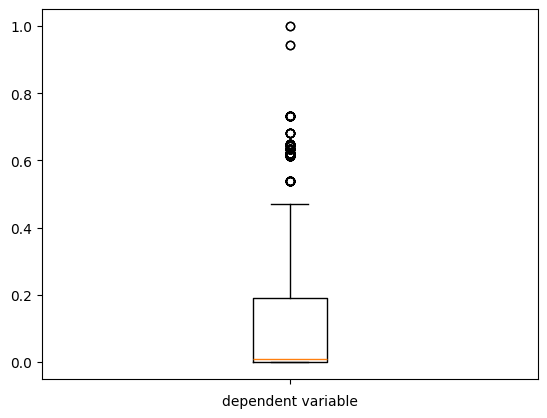

In [232]:
# Print dependent variable
import numpy as np
import matplotlib.pyplot as plt

# plot the data
fig,ax = plt.subplots(1)
#weather plot the data
plt.boxplot(df[["cont_dependent"]])
plt.xlabel("dependent variable")
ax.set_xticklabels([])

plt.plot()

### Independent variable

In [233]:
# Normalise the desired variables
df["norm_damages"] = (df["Total Damages"] - df["Total Damages"].min()) / (df["Total Damages"].max() - df["Total Damages"].min())
df["norm_deaths"] = (df["Total Deaths"] - df["Total Deaths"].min()) / (df["Total Deaths"].max() - df["Total Deaths"].min())
df["norm_affected"] = (df["Total Affected"] - df["Total Affected"].min()) / (df["Total Affected"].max() - df["Total Affected"].min())

# normalisation by z-score method
df["z_norm_damages"] = (df["Total Damages"] - df["Total Damages"].mean()) / df["Total Damages"].std()
df["z_norm_deaths"] = (df["Total Deaths"] - df["Total Deaths"].mean()) / df["Total Deaths"].std()
df["z_norm_affected"] = (df["Total Affected"] - df["Total Affected"].mean()) / df["Total Affected"].std()

In [234]:
# replace NaN with 0
df["norm_damages"] = df["norm_damages"].fillna(0)
df["norm_deaths"] = df["norm_deaths"].fillna(0)
df["norm_affected"] = df["norm_affected"].fillna(0)
df["z_norm_damages"] = df["z_norm_damages"].fillna(0)
df["z_norm_deaths"] = df["z_norm_deaths"].fillna(0)
df["z_norm_affected"] = df["z_norm_affected"].fillna(0)

# compute weighted score
df["cont_independent"] = (df["norm_damages"] * WEIGHTS["damages"] + \
                       df["norm_deaths"] * WEIGHTS["deaths"] + \
                       df["norm_affected"] * WEIGHTS["affected"])

df["z_cont_independent"] = (df["z_norm_damages"] * WEIGHTS["damages"] + \
                       df["z_norm_deaths"] * WEIGHTS["deaths"] + \
                       df["z_norm_affected"] * WEIGHTS["affected"])


[]

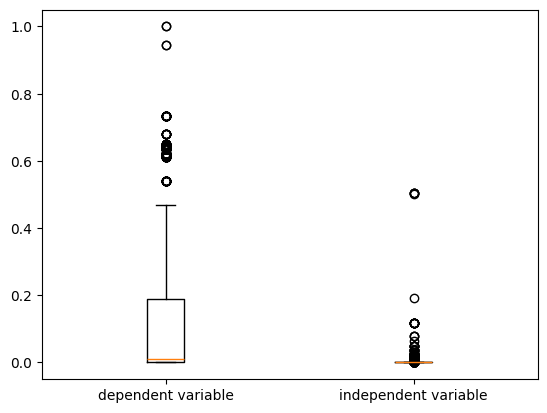

In [235]:
# Print independent variable
import numpy as np
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1)
#weather plot the data
plt.boxplot(df[["cont_dependent", "cont_independent"]])
ax.set_xticklabels(["dependent variable", "independent variable"])

plt.plot()

### Map plot

/var/folders/fc/nmrtwsyj4cx9_51gmbxm2lb80000gn/T/ipykernel_20104/446962484.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world: pd.DataFrame = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


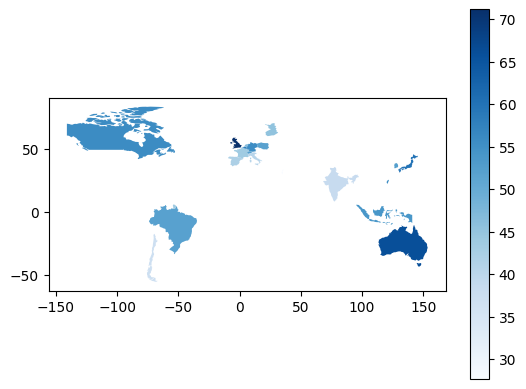

In [256]:
import geopandas as gpd

world: pd.DataFrame = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
outages_by_country = df[["country", "cont_dependent"]].groupby(by=["country"]).sum()
merged_df = world.merge(outages_by_country, left_on="name", right_on="country")

merged_df.plot(column="cont_dependent", cmap="Blues", legend=True)
plt.show()

/var/folders/fc/nmrtwsyj4cx9_51gmbxm2lb80000gn/T/ipykernel_20104/1963735460.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world: pd.DataFrame = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


KeyError: 'cont_dependent'

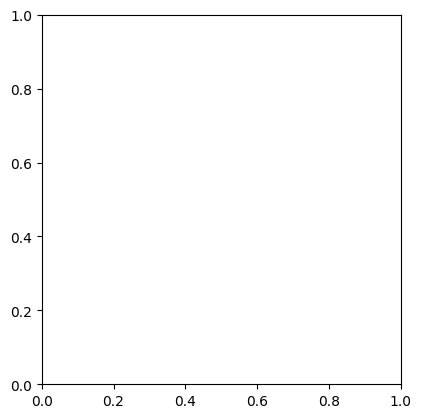

In [257]:
import geopandas as gpd

world: pd.DataFrame = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
outages_by_country = df[["country", "cont_independent"]].groupby(by=["country"]).sum()
merged_df = world.merge(outages_by_country, left_on="name", right_on="country")

merged_df.plot(column="cont_independent", cmap="Reds", legend=True)
plt.show()

## Linear regression

In [236]:
df[df["cont_independent"] > 0.4]

,Unnamed: 0,Unnamed: 0_x,date,country,id,start,end,severity,status,location,...,cont_dependent,z_cont_dependent,norm_damages,norm_deaths,norm_affected,z_norm_damages,z_norm_deaths,z_norm_affected,cont_independent,z_cont_independent
74,74,86,2022-09-18,Japan,urNR4xD4gBNsyaZj3W1i,2022-09-15 23:01:57+00:00,2022-09-29 20:49:04+00:00,low,SERVICE_INFORMATION,asia-northeast1,...,0.421024,0.422688,1.0,0.012012,0.000607,1.491544,-0.302969,-0.241738,0.504865,0.600410
99,99,114,2022-09-19,Japan,tK27wxVTmR9qpxvE1oJw,2022-09-19 16:51:00+00:00,2022-09-19 19:40:00+00:00,medium,SERVICE_DISRUPTION,asia-northeast1,...,0.340688,0.542603,1.0,0.012012,0.000607,1.491544,-0.302969,-0.241738,0.504865,0.600410
100,100,115,2022-09-19,Japan,urNR4xD4gBNsyaZj3W1i,2022-09-15 23:01:57+00:00,2022-09-29 20:49:04+00:00,low,SERVICE_INFORMATION,asia-northeast1,...,0.421024,0.422688,1.0,0.012012,0.000607,1.491544,-0.302969,-0.241738,0.504865,0.600410
134,134,151,2022-09-20,Japan,urNR4xD4gBNsyaZj3W1i,2022-09-15 23:01:57+00:00,2022-09-29 20:49:04+00:00,low,SERVICE_INFORMATION,asia-northeast1,...,0.421024,0.422688,1.0,0.012012,0.000607,1.491544,-0.302969,-0.241738,0.504865,0.600410
2056,2056,2306,2022-11-21,Indonesia,NaN,NaT,NaT,NaN,NaN,NaN,...,0.000000,0.000000,0.0,1.000000,1.000000,0.000000,10.683065,12.274717,0.500000,5.500698


Coefficients: 
 [0.34232649]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     5.396
Date:                Sat, 07 Oct 2023   Prob (F-statistic):             0.0202
Time:                        13:32:37   Log-Likelihood:                 2809.2
No. Observations:                9571   AIC:                            -5614.
Df Residuals:                    9569   BIC:                            -5600.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1186  

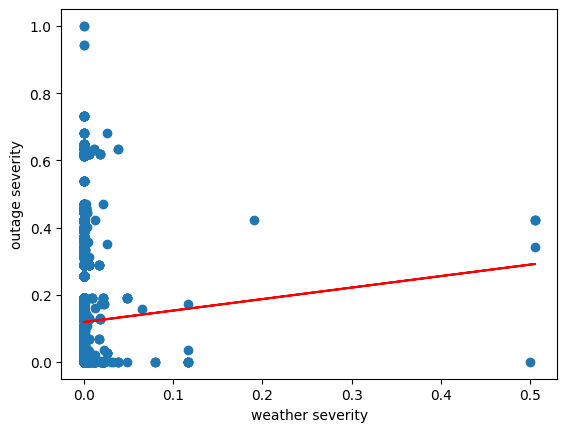

In [237]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.api as sm

# plot the data
plt.scatter(df["cont_independent"], df["cont_dependent"], )
plt.xlabel("weather severity")
plt.ylabel("outage severity")
# plt.savefig("outages_weather_scatter.png")


# model using linear regression
X = df["cont_independent"].to_numpy().reshape(-1, 1)
Y = df["cont_dependent"].to_numpy()
reg = linear_model.LinearRegression()
reg.fit(X, Y)
print("Coefficients: \n", reg.coef_)

predicted_Y = reg.predict(X)

plt.plot(X, predicted_Y, color="red")


X = sm.add_constant(X) # add const to allow for constant offset of gradient
stats_results = sm.OLS(Y, X).fit()
print(stats_results.summary())

Coefficients: 
 [[0.90649414]]
Optimization terminated successfully.
         Current function value: 0.547824
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 9571
Model:                          Logit   Df Residuals:                     9569
Method:                           MLE   Df Model:                            1
Date:                Sat, 07 Oct 2023   Pseudo R-squ.:               0.0004046
Time:                        13:41:28   Log-Likelihood:                -5243.2
converged:                       True   LL-Null:                       -5245.3
Covariance Type:            nonrobust   LLR p-value:                   0.03937
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1697      0.024    -48.602      0.000      -1.217      -1.12

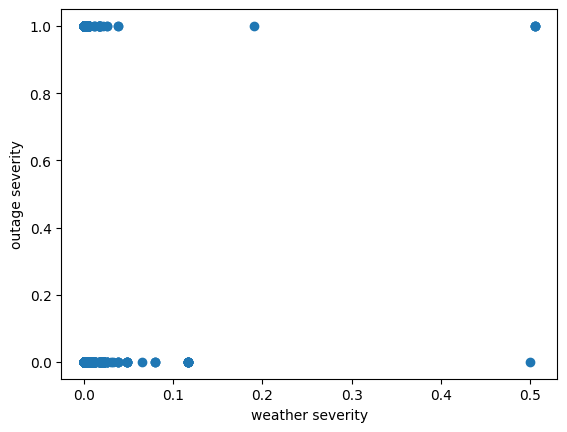

In [239]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.api as sm

df.loc[df['cont_dependent'] <= 0.2, 'binary_dependent'] = 0
df.loc[df['cont_dependent'] > 0.2, 'binary_dependent'] = 1

# plot the data
# plt.scatter(df["cont_independent"], df["binary_dependent"], )
plt.xlabel("weather severity")
plt.ylabel("outage severity")
# plt.savefig("outages_weather_scatter.png")


# model using linear regression
X = df["cont_independent"].to_numpy().reshape(-1, 1)
Y = df["binary_dependent"].to_numpy()
reg = linear_model.LogisticRegression()
reg.fit(X, Y)
print("Coefficients: \n", reg.coef_)

predicted_Y = reg.predict(X)

# plt.scatter(X, Y, c=predicted_Y)
plt.scatter(X, Y)

X = sm.add_constant(X) # add const to allow for constant offset of gradient
stats_results = sm.Logit(Y, X).fit()
print(stats_results.summary())